# Исследование данных о продажах видеоигр в интернет-магазине

## Введение

Работа проводиться в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й.

План работы:
1. Подготовка данных к анализу.
2. Исследовательский анализ данных.
3. Составление портрета пользователя для каждого региона.
4. Статистический анализ данных.
5. Вывод и рекомендации 

Описание данных
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.


## Предобработка данных.

Импортируем необходимые библиотеки

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats as st

Загрузим датафрейм и выведем его первые 5 строк

In [2]:
try:   
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Узнаем общую информацию про полученный датафрейм

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Все названия столбцов начинаются с заглавной буквы, что не соответствует правилам оформления змеиного регистра. Приведем их к нужной форме. 

In [4]:
data = data.rename(str.lower, axis='columns')

Обработаем пропуски в датафрейме.

Для начала выведем их общее количество. 


In [5]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Обработаем пропуски в столбце name.

Пропусков в столбце name всего 2, можно их удалить, так как это не приведет к значительным изменениям в дальнейшем изучении нашего датафрейма.  


In [6]:
data = data.dropna(subset=['name'])

Обработаем пропуски в столбце year_of_release.

Некоторые игры выходили на нескольких платформах одновременно. Если у игры с неизвестной датой релиза есть дата релиза на другой платформе, то примем дату первого известного релиза этой игры.

In [7]:
for n in data.loc[data['year_of_release'].isna(), 'name']:
    data.loc[(data['name'] == n) & (data['year_of_release'].isna()), 'year_of_release'] = \
    data.loc[(data['name'] == n) & (~data['year_of_release'].isna()), 'year_of_release'].min()

Некоторое количество пропусков мы убрали.

Обычно у игр с жанром “Спортивный симулятор” присутствует год в названии. Дата выпуска таких игр соответствует году в названии минус 1 год.
Найдем оставшиеся игры с пропуском в колонке year_of_release и заполним по такой логике. 

In [8]:
for i in data.loc[data['year_of_release'].isna(), 'name']:
    if ('200' in i) or ('9' in i):
        print(i)

wwe Smackdown vs. Raw 2006
Triple Play 99
NFL GameDay 2003
All-Star Baseball 2005
All-Star Baseball 2005
Drake of the 99 Dragons
Sega Rally 2006
Football Manager 2007


In [9]:
data.loc[(data['name'] == 'wwe Smackdown vs. Raw 2006') | (data['name'] == 'Sega Rally 2006'), 'year_of_release'] = 2005
data.loc[data['name'] == 'Triple Play 99', 'year_of_release'] = 1998
data.loc[data['name'] == 'NFL GameDay 2003', 'year_of_release'] = 2002
data.loc[data['name'] == 'All-Star Baseball 2005', 'year_of_release'] = 2004
data.loc[data['name'] == 'Football Manager 2007', 'year_of_release'] = 2006

Обработаем пропуски в столбце rating.

Возьмем значения возрастной категории у другой такой же игры, только с другой платформы, т.к. возрастная категория не должна зависеть от платформы.

In [10]:
for m in data.loc[data['rating'].isna(), 'name']:
    data.loc[(data['name'] == m) & (data['rating'].isna()), 'rating'] = \
    data.loc[(data['name'] == m) & (~data['rating'].isna()), 'rating'].min()

Остальные пропуски в столбце rating заменим заглушкой “Unknown” 

In [11]:
data['rating'] = data['rating'].fillna('Unknown')

Оставшиеся количество пропусков:

In [12]:
data.isna().sum()

name                  0
platform              0
year_of_release     139
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating                0
dtype: int64

Оставшиеся пропуски оставим как есть и вот почему: колонку year_of_release не получится корректно заполнить средним или медианой, так как игры могут выходить в любое время не зависимо от какого-либо фактора, а колонки critic_score, user_score и rating имеют слишком много пропусков и если запонять все эти пропуски самому, то это может сильно отразиться на дальнейшим исследовании.


**Какие причины могут привести к пропускам:**

* Колонка name – вероятно, ошибка выгрузки или наоборот ошибка при первоначальном заполнении. Хотя такая причина применима и к пропускам в других столбцах, поэтому далее ее упоминать не будем.
* Колонка year_of_release – может быть игра совсем старая и точную дату выпуска сложно найти в открытых источниках.
* Колонка critic_score, user_score – вероятно, что игра совсем новая и оценки не успели сформироваться. Может быть, игра выходила ограниченным тиражом, и она не набрала нужное количество голосов для корректного отображения оценки на сайте. Может быть игра совсем старая и оценки, которые выставляли на тот момент, не сохранились на текущий момент времени.
* Колонка rating – присваиванием рейтинга занимается определенная организация, ее параметры рейтинга могут меняться со временем и в тот момент, когда они меняют критерии, старые критерии утрачивают свою силу, приходиться переписывать старые значения на новые, в такой момент может произойти неожиданное затирание. 


В колонке user_score присутствует параметр “tbd” – аббревиатура от английского To Be Determined (будет определено) (определение взято из открытого источника). Это означает что игра не набрала достаточное количество голосов для формирования оценки.

Преобразуем данные в нужные типы.

Выведем еще раз общую информацию.

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16574 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           16713 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Из полученной информации видно, что хотелось бы преобразовать колонку year_of_release в int, из-за того, что год не может быть с дробной частью, но из-за оставшихся пропусков мы не можем это сделать. Преобразуем колонку user_score в тип float, так как хотелось бы представить оценки как число с плавающей точкой. Значения ‘tbd’ заменим на None.

In [14]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

Проверим есть ли в датафрейме дубликаты.  

In [15]:
data.duplicated().sum()

0

Дубликатов нет!   

Создадим столбец total_sales, который объединяет столбцы na_sales, eu_sales, jp_sales.   

In [16]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

Посчитаем общие продажи по регионам.

In [17]:
data_total_sales = data[['na_sales','eu_sales','jp_sales','other_sales']].sum()
data_total_sales

na_sales       4400.57
eu_sales       2424.14
jp_sales       1297.34
other_sales     791.24
dtype: float64

Отобразим полученные данные на столбчатой диаграмме.

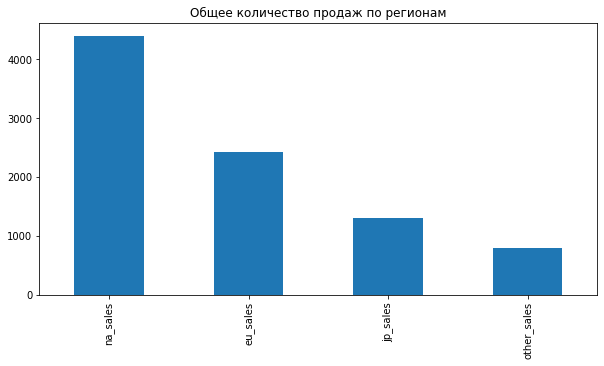

In [18]:
data_total_sales.plot.bar(figsize=(10,5));
plt.title('Общее количество продаж по регионам')
plt.show()

Вывод: Наибольшие количество продаж наблюдается в NA регионе. Количество продаж в NA регионе больше суммы продаж в остальных регионах.

## Исследовательский анализ данных.

Посмотрим сколько игр выпускалось в разные годы.

In [19]:
data_games_in_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
data_games_in_year

,name
year_of_release,
1980.0,9
1981.0,46
1982.0,36
1983.0,17
1984.0,14
1985.0,14
1986.0,21
1987.0,16
1988.0,15


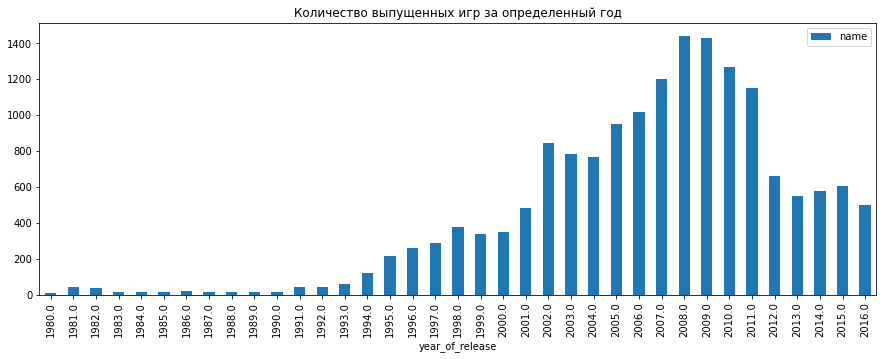

In [20]:
data_games_in_year.plot.bar(figsize=(15,5));
plt.title('Количество выпущенных игр за определенный год')
plt.show()

Посмотрим сколько игр выпускалось в разные годы.

In [21]:
data_unique_games_in_year = data.drop_duplicates(subset=['name']).pivot_table(index='year_of_release', values='name', aggfunc='count')
data_unique_games_in_year

,name
year_of_release,
1980.0,8
1981.0,43
1982.0,33
1983.0,16
1984.0,13
1985.0,13
1986.0,21
1987.0,15
1988.0,11


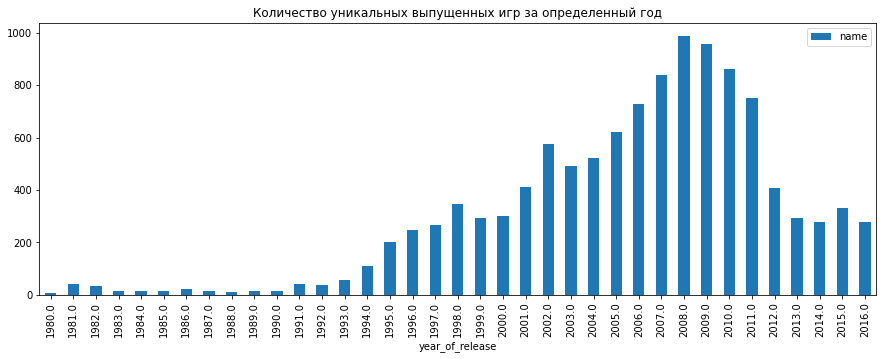

In [22]:
data_unique_games_in_year.plot.bar(figsize=(15,5));
plt.title('Количество уникальных выпущенных игр за определенный год')
plt.show()

Взглянув на столбчатую диаграмму, можно увидеть:

- Рост производства видеоигр начался с 1993 года.
- Пик производства видеоигр приходиться на 2008-2009 год.
- С 1980 по 1991 игры выпускались в малом количестве. 

Хоть с 1980 по 1991 приходится малый объем выпущенных видеоигр, мы все ровно примем эти данные во внимание, по причине того что в данных промежуток времени могут быть данные о играх с платформ, которые могли перестать существовать в последующий промежуток времени. 


Посмотрим как менялись продажи по платформам.

In [23]:
data_platform_sales = data.pivot_table(
    index='platform',
    values='total_sales',
    aggfunc='sum').sort_values(by='total_sales', ascending=False)
data_platform_sales

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


Из получившийся таблицы возьмем топ 15 платформ по количеству продаж и построим диаграмму распределения продаж по годам. 

In [24]:
data_platform_sales = data_platform_sales.query('total_sales > 214')
data_platform_sales

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


Создадим функцию для построения столбчатой диаграммы для определенной платформы.

In [25]:
def platform_bar(name):
    data.query(
        'platform == @name and total_sales != 0'
    ).pivot_table(
        index='year_of_release',
        values='total_sales',
        aggfunc='sum'
    ).plot.bar(
        figsize=(15,5)
    )
    plt.title(f'Количество продаж по годам для {name}')
    return plt.show()

Построим столбчатые диаграммы для нашего топ 15 платформ по количеству продаж. 

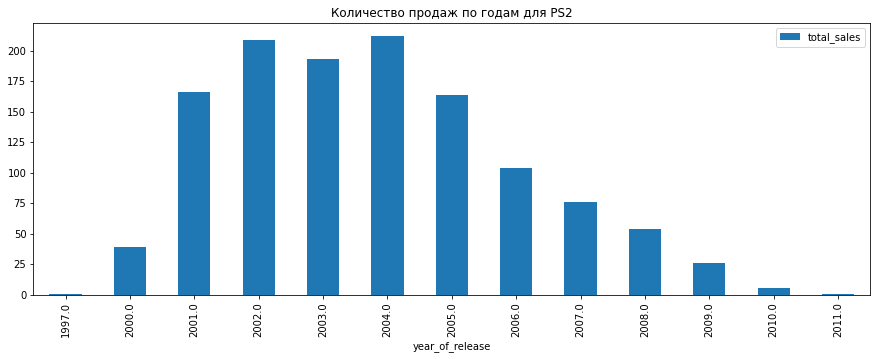

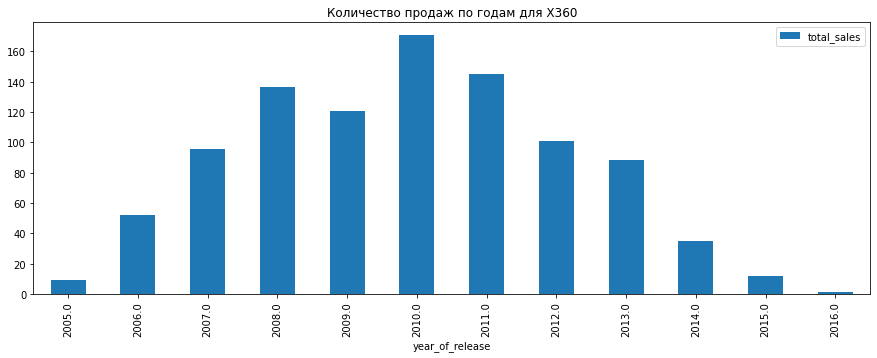

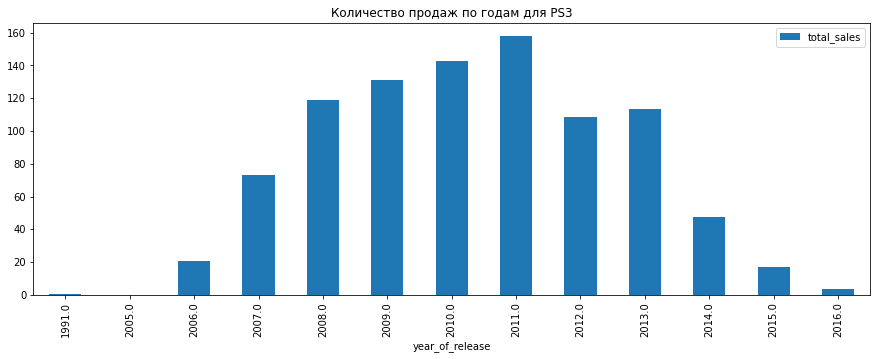

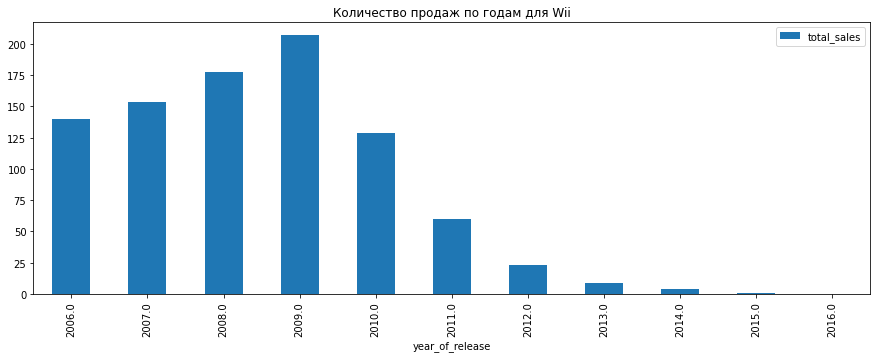

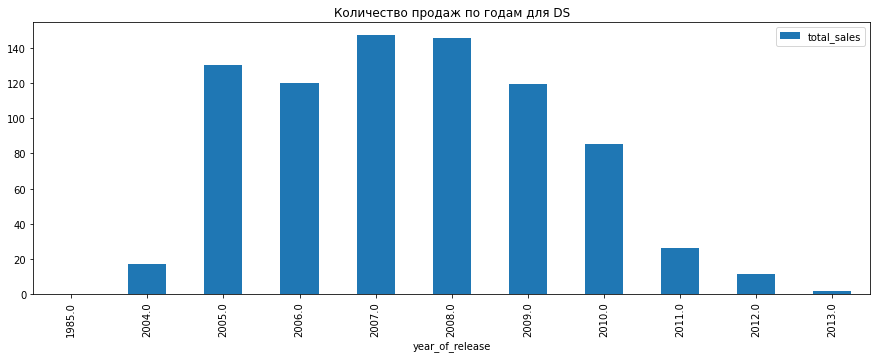

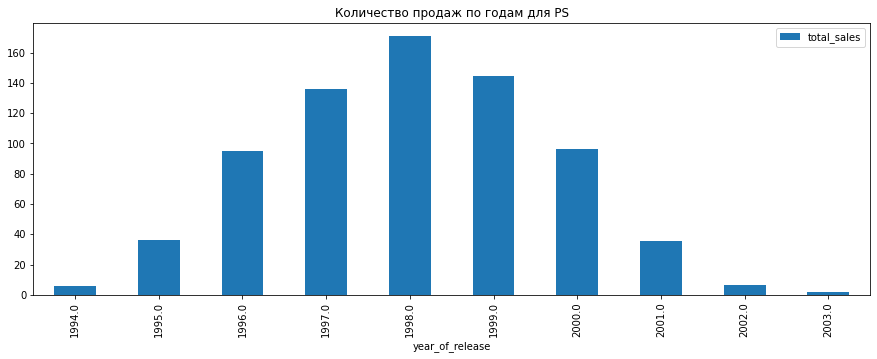

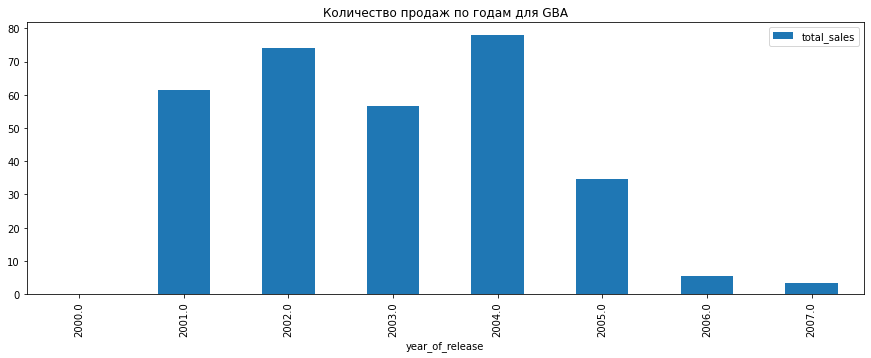

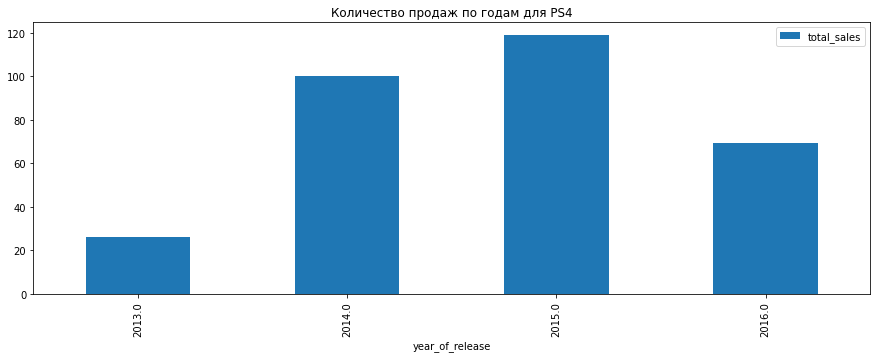

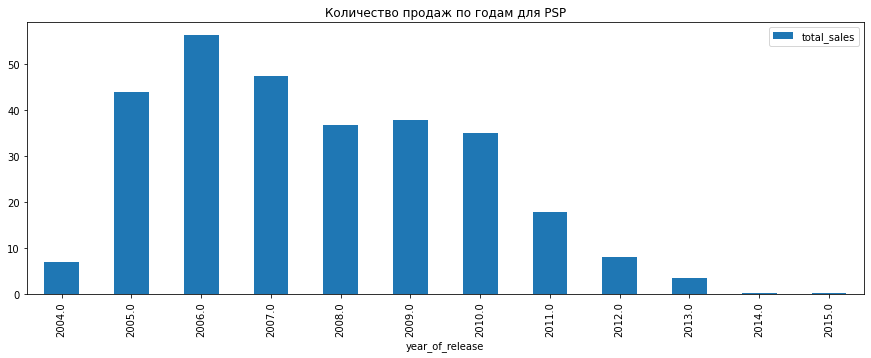

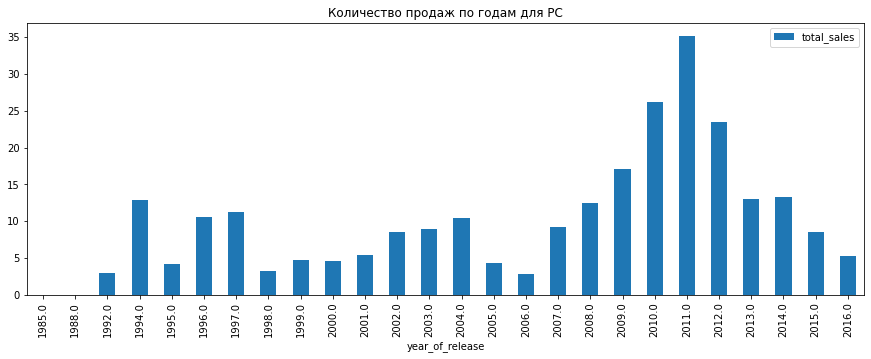

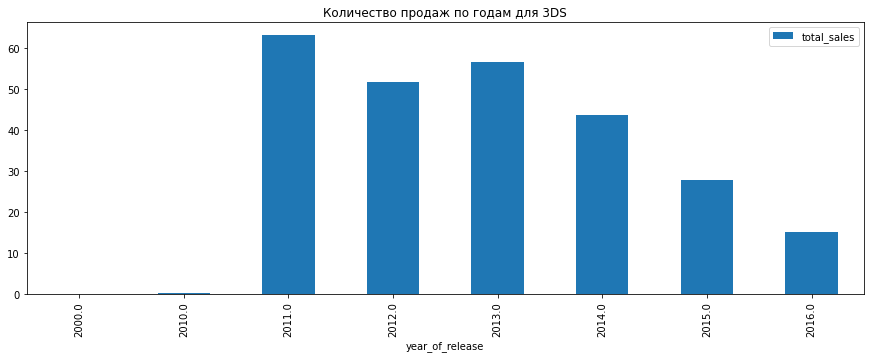

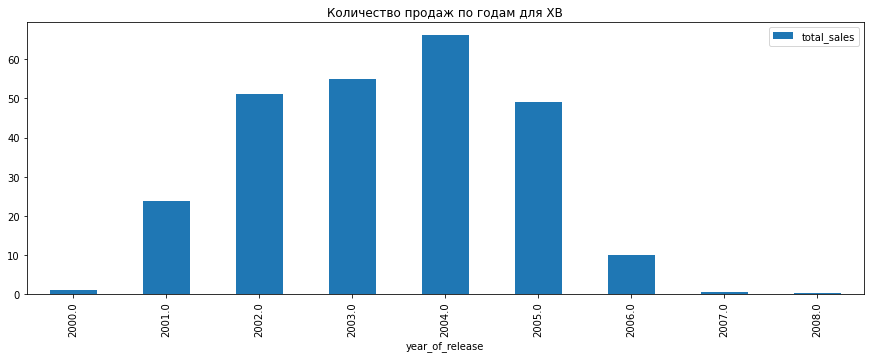

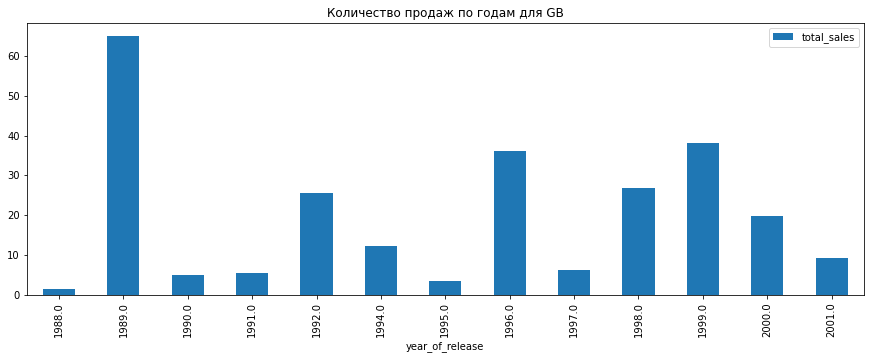

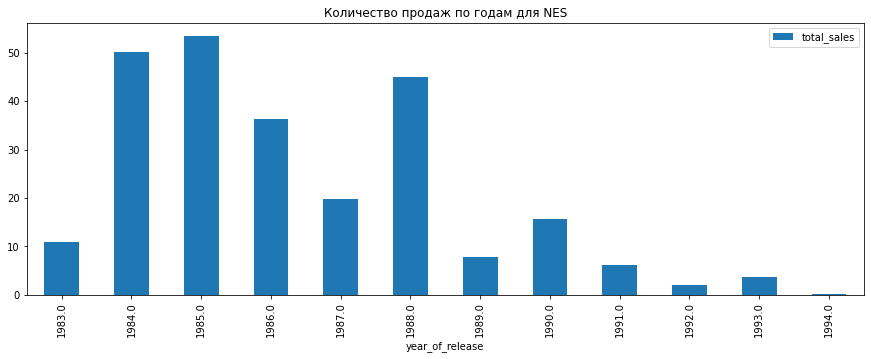

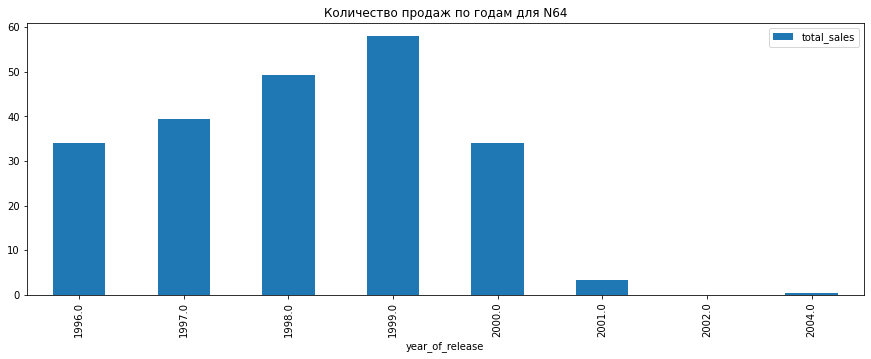

In [26]:
for i in range(0,15):
    platform_bar(data_platform_sales.index.tolist()[i])

Из диаграмм видно, что старые платформы исчезают постепенно в течении 3-5 лет. Новые же платформы появляются за 1-2 года.

Посчитаем средний срок существования платформ  

In [27]:
top_platform = data_platform_sales.index.tolist()
mean_time = len(
    data.query(
        'platform == @top_platform and platform != "PC"'
    ).pivot_table(
        index=['platform','year_of_release'],
        values='name',
        aggfunc='count'
    )
) / 14
print(f'Средний жизненный срок существования консоли: {mean_time:.1f}')

Средний жизненный срок существования консоли: 10.3


Средний срок существования консолей равен 10 лет. В расчет не была взята платформа “PC”, так как он не является консолью.  

Возьмем данные за соответствующий актуальный период - последние 5 лет.

Это период был выбран из-за того, что основной фактор исследования – прогноз на 2017 год. Платформы, которые были популярны раньше 2012 года уже теряют свою популярность.


In [28]:
data = data.query('year_of_release > 2011')

Построим диаграммы для платформ по количеству продаж уже за актуальный период.

In [29]:
data_platform_sales_actual = data.pivot_table(
    index='platform',
    values='total_sales',
    aggfunc='sum').sort_values(by='total_sales', ascending=False)
data_platform_sales_actual

,total_sales
platform,
PS4,314.14
PS3,289.71
X360,237.52
3DS,195.01
XOne,159.32
WiiU,82.19
PC,63.51
PSV,49.18
Wii,36.60


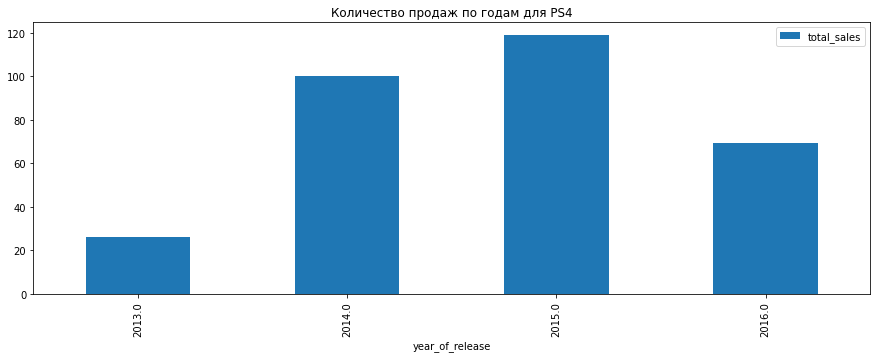

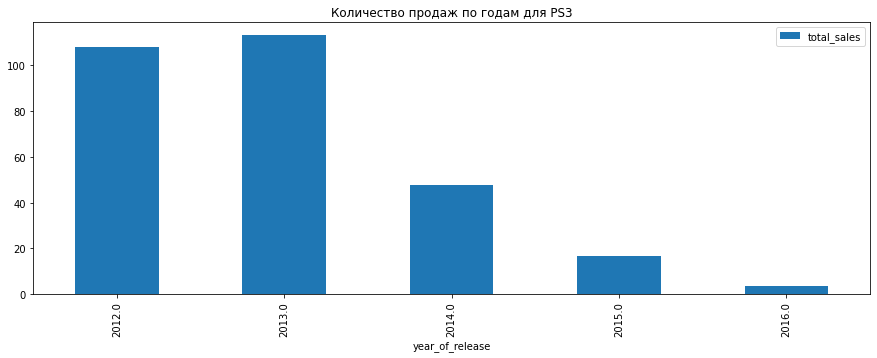

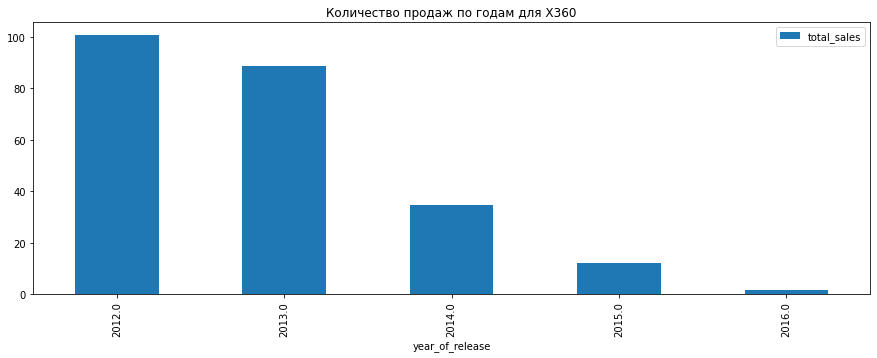

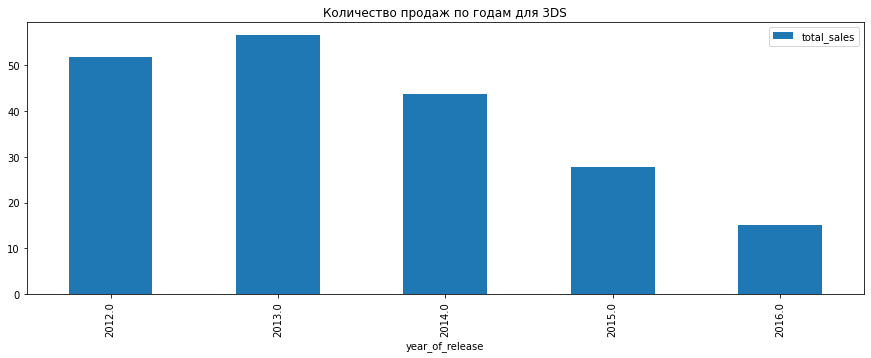

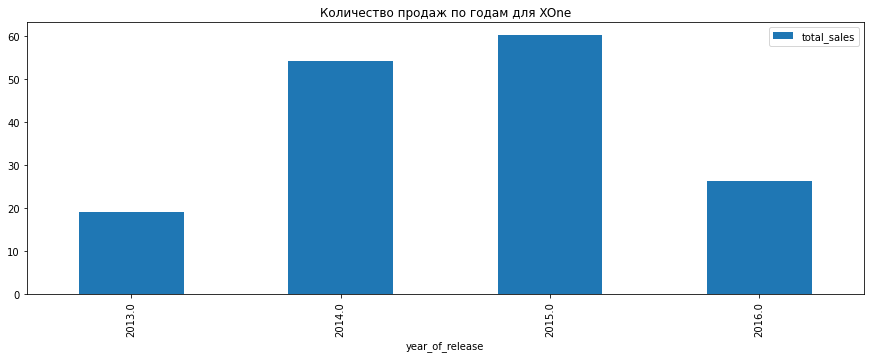

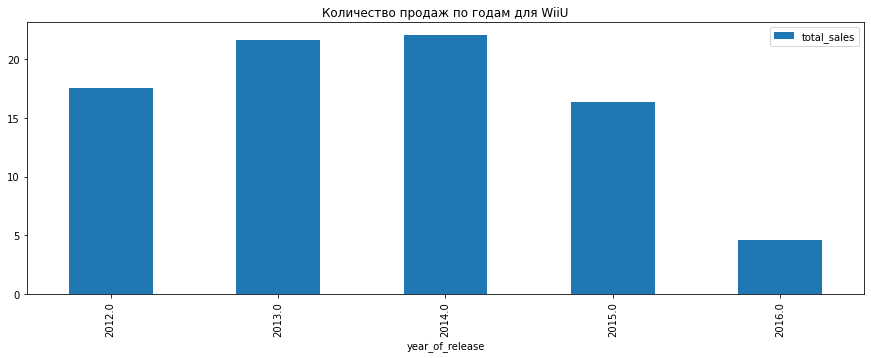

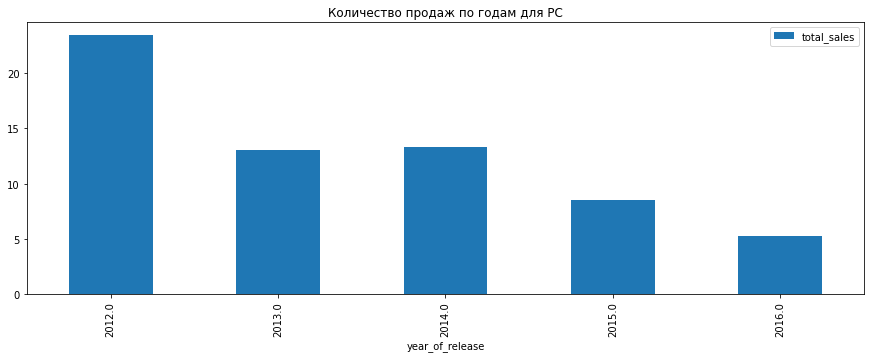

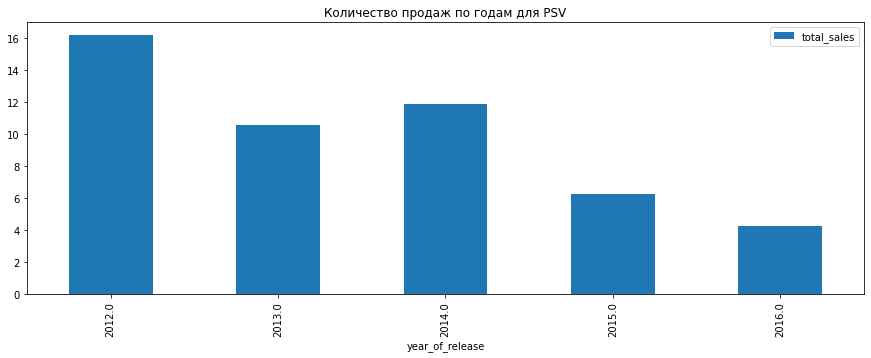

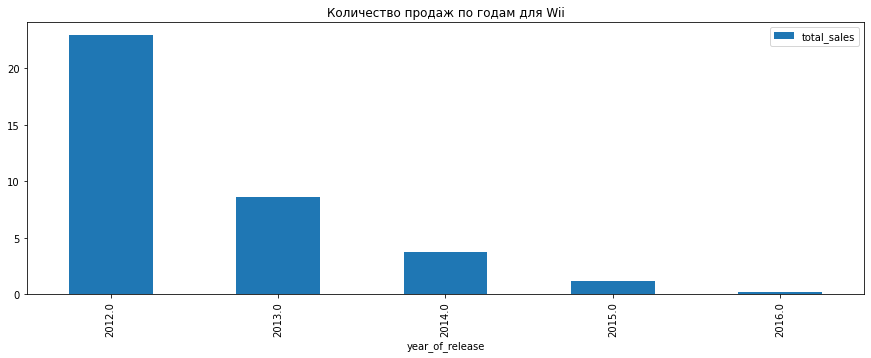

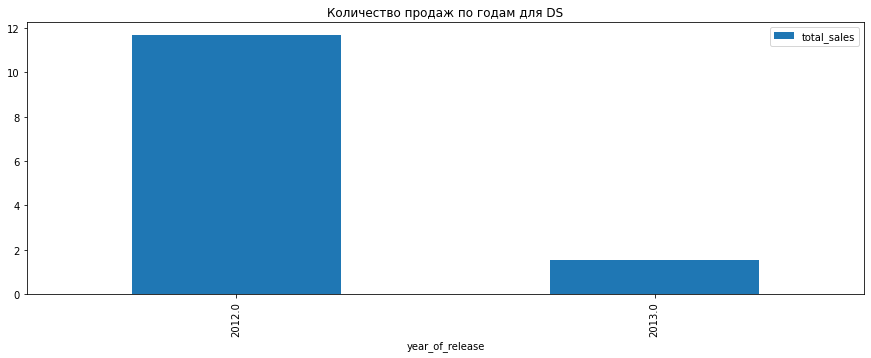

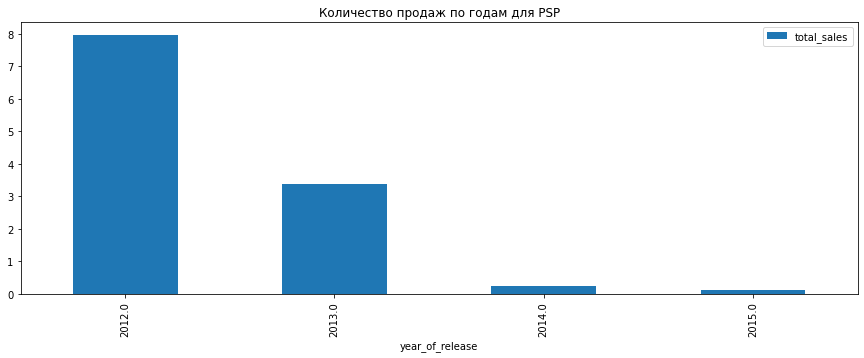

In [30]:
for i in range(0,len(data_platform_sales_actual)):
    platform_bar(data_platform_sales_actual.index.tolist()[i])
    plt.ylim

По диаграмме видно, что спад наблюдается почти на всех платформах.Если учитывать, что данные за 2016 год неполные, то можно предположить что есть платформы на подъеме - это PS4 и XOne. Наиболее прибыльные платформы за 2016 год это PS4, XOne, 3DS. Также видно, что есть средне прибыльные платформы с не очень большим спадом по годами актуального периода – это PC и PSV. Выберем PS4, XOne, 3DS, PC, PSV как потенциально прибыльные платформы.

Построим boxplot’ы для выбранных платформ. 

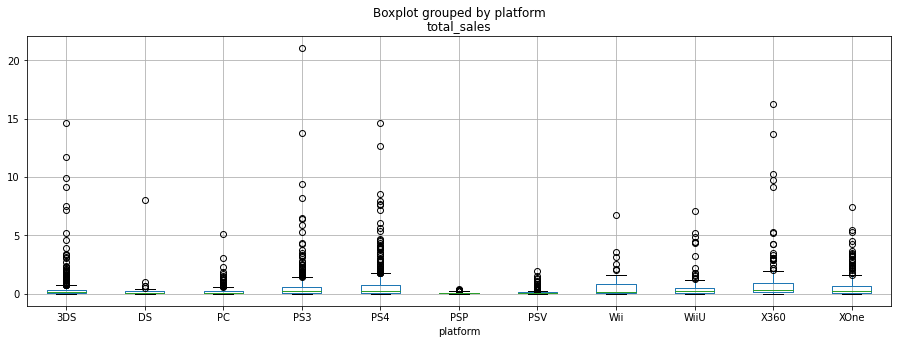

In [31]:
data.boxplot('total_sales', by='platform', figsize=(15,5));

Почти на каждом графике первый квантиль boxplot’а сильно смещен к 0. Есть игры, продажи который составляют больше 6 млн. и сильно отрываются от своих конкурентов. Для дальнейшего исследования уберем игры-выбросы, продажи которых более 6 млн. 

In [32]:
data = data.query('total_sales < 6')

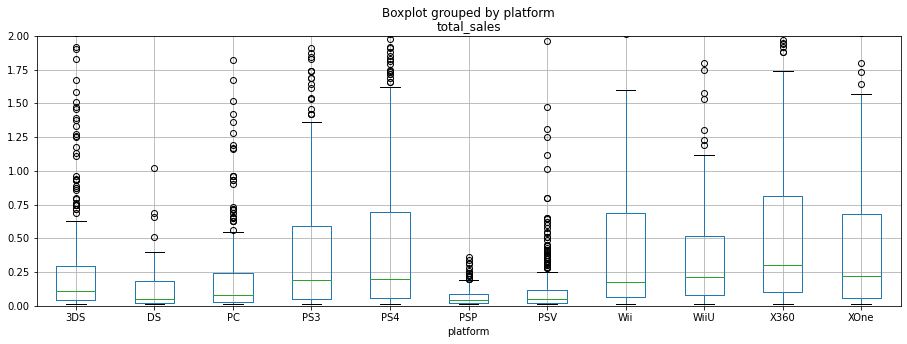

In [33]:
ax = data.boxplot('total_sales', by='platform', figsize=(15,5));
ax.set_ylim(0,2)
ax;

Такое смещение обусловленной тем, что в датафрейме много игры с небольшим количеством продаж. Отмечу, что для таких платформ как DS, PC, PSP, PSV почти все значения продаж лежат ниже 0.5 млн.

Посмотрим как влияют на продажи внутри PS4 отзывы пользователей и критиков.

In [34]:
data_ps4 = data.query('platform == "PS4"')

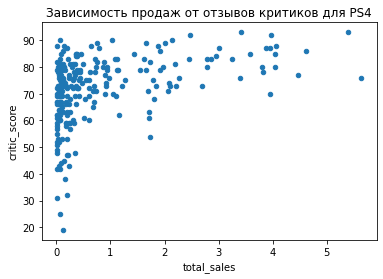

In [35]:
data_ps4.plot(x='total_sales', y='critic_score', kind='scatter');
plt.title('Зависимость продаж от отзывов критиков для PS4')
plt.show;

In [36]:
print('Коэффициент корреляции Пирсона:', data_ps4['total_sales'].corr(data_ps4['critic_score']))

Коэффициент корреляции Пирсона: 0.4046925924429624


Корреляция положительная, но не очень сильная, зависимость есть.  

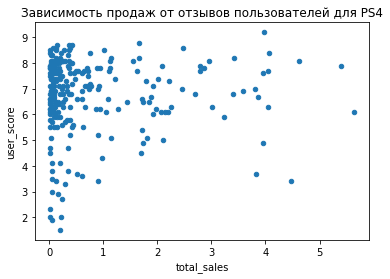

In [37]:
data_ps4.plot(x='total_sales', y='user_score', kind='scatter');
plt.title('Зависимость продаж от отзывов пользователей для PS4')
plt.show;

In [38]:
print('Коэффициент корреляции Пирсона:', data_ps4['total_sales'].corr(data_ps4['user_score']))

Коэффициент корреляции Пирсона: 0.018301740249559405


Корреляция положительная, но почти равно нулю, можно сказать что зависимости нет.    

Вывод: Большинство пользователей PS4 при покупке не ориентируются на отзывы.

Посчитаем корреляцию для уже для всех платформ.

In [39]:
data_not_ps4 = data.query('platform != "PS4"')
print('Коэффициент корреляции Пирсона:', data_not_ps4['total_sales'].corr(data_not_ps4['critic_score']))

Коэффициент корреляции Пирсона: 0.3456352514618713


In [40]:
print('Коэффициент корреляции Пирсона:', data_not_ps4['total_sales'].corr(data_not_ps4['user_score']))

Коэффициент корреляции Пирсона: 0.0319510554453672


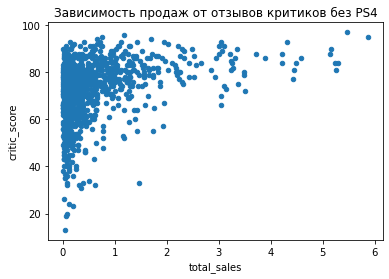

In [41]:
data_not_ps4.plot(x='total_sales', y='critic_score', kind='scatter');
plt.title('Зависимость продаж от отзывов критиков без PS4')
plt.show;

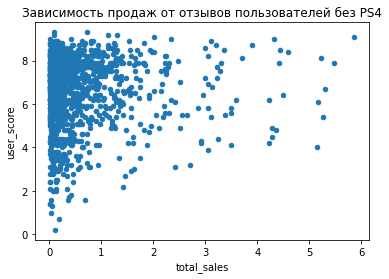

In [42]:
data_not_ps4.plot(x='total_sales', y='user_score', kind='scatter');
plt.title('Зависимость продаж от отзывов пользователей без PS4')
plt.show;

Вывод: Корреляция PS4 близка к корреляции для всех платформ, выводы сделанные для PS4 можно считать справедливыми для всех платформ.

Посмотрим на общее распределение игр по жанрам

In [43]:
data.pivot_table(index='genre', values='name', aggfunc='count').sort_values(by='name', ascending=False)

,name
genre,
Action,1036
Role-Playing,365
Adventure,302
Sports,264
Shooter,228
Misc,191
Racing,114
Fighting,108
Platform,84


Больше всего игр выпускают в жанре Action, а меньше всего в жанре Puzzle. 

Посмотрим на медийное значение продаж по жанрам

In [44]:
data.pivot_table(index='genre', values='total_sales', aggfunc='median').sort_values(by='total_sales', ascending=False)

,total_sales
genre,
Shooter,0.410
Sports,0.235
Platform,0.200
Racing,0.135
Fighting,0.130
Role-Playing,0.130
Action,0.120
Misc,0.120
Simulation,0.120


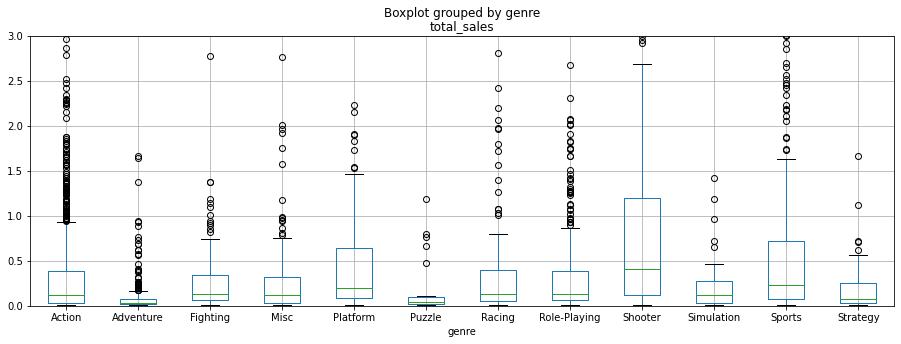

In [45]:
ax = data.boxplot('total_sales', by='genre', figsize=(15,5));
ax.set_ylim(0,3)
ax;

Медиана делит нашу выборку пополам, это означает что чем больше медиана, тем больше и стабильный доход по жанру. Самыми доходными жанрами можно назвать Shooter, Sports и Platform, которые не даже не попали в топ-3 по количеству выпущенных игр по жанрам. Жанр Acton, который занимал первое место по количеству выпущенных игр находится на седьмом месте в списке по медийным значениям доходности. 

## Составим портрет пользователя каждого региона

Определим самые популярные платформы (топ-5) для каждого региона. 

In [46]:
top_na_platform = data.pivot_table(
    index='platform',
    values='na_sales'
    , aggfunc='sum'
).sort_values(
    by='na_sales',
    ascending=False
).head()

top_na_platform['procent_na_sales'] = top_na_platform['na_sales'] / data['na_sales'].sum() * 100

top_na_platform

,na_sales,procent_na_sales
platform,,
X360,103.58,21.639125
XOne,88.53,18.494997
PS4,87.84,18.350847
PS3,83.15,17.371049
WiiU,34.95,7.301481


В регионе NA первые 4 места распределены почти равномерно и имеют примерно по 20% от общих продаж.   

In [47]:
top_eu_platform = data.pivot_table(
    index='platform',
    values='eu_sales',
    aggfunc='sum'
).sort_values(
    by='eu_sales'
    , ascending=False
).head()

top_eu_platform['procent_eu_sales'] = top_eu_platform['eu_sales'] / data['eu_sales'].sum() * 100

top_eu_platform

,eu_sales,procent_eu_sales
platform,,
PS4,102.48,25.662343
PS3,77.05,19.294336
X360,58.02,14.528973
XOne,49.48,12.390444
PC,38.38,9.610858


В регионе EU лидируют платформы марки PS (PS3, PS4), их общая доля от всех продаж составляет 45 процентов.

In [48]:
top_jp_platform = data.pivot_table(
    index='platform',
    values='jp_sales',
    aggfunc='sum'
).sort_values(
    by='jp_sales',
    ascending=False
).head()

top_jp_platform['procent_jp_sales'] = top_jp_platform['jp_sales'] / data['jp_sales'].sum() * 100

top_jp_platform

,jp_sales,procent_jp_sales
platform,,
3DS,68.79,41.625318
PS3,32.92,19.920126
PSV,21.04,12.731453
PS4,14.43,8.731696
WiiU,11.73,7.097906


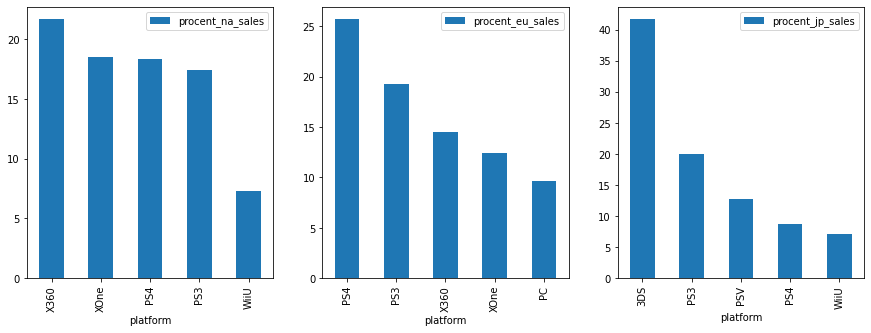

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5))

top_na_platform.plot.bar(y='procent_na_sales',ax=axes[0])
top_eu_platform.plot.bar(y='procent_eu_sales',ax=axes[1])
top_jp_platform.plot.bar(y='procent_jp_sales',ax=axes[2]);

В регионе JP лидирует платформа 3DS. Ее продажи составляют 41 процентов от общих продаж и  сопоставимы с конкурентами на втором, третьем и четвертом месте вместе взятые.

Определим самые популярные жанры (топ-5) для каждого региона.

In [50]:
top_na_genre = data.pivot_table(
    index='genre',
    values='na_sales'
    , aggfunc='sum'
).sort_values(
    by='na_sales',
    ascending=False
).head()

top_na_genre['procent_na_sales'] = top_na_genre['na_sales'] / data['na_sales'].sum() * 100

top_na_genre

,na_sales,procent_na_sales
genre,,
Action,155.81,32.550609
Shooter,97.65,20.400276
Sports,78.17,16.330666
Role-Playing,46.07,9.624585
Misc,28.44,5.941463


В регионе NA лидирует жанры Action, Shooter и Sports. Их общая доля от всех продаж составляет почти 70 процентов от всех продаж. 

In [51]:
top_eu_genre = data.pivot_table(
    index='genre',
    values='eu_sales'
    , aggfunc='sum'
).sort_values(
    by='eu_sales',
    ascending=False
).head()

top_eu_genre['procent_eu_sales'] = top_eu_genre['eu_sales'] / data['eu_sales'].sum() * 100

top_eu_genre

,eu_sales,procent_eu_sales
genre,,
Action,133.63,33.462713
Shooter,80.09,20.055592
Sports,48.65,12.182601
Role-Playing,34.41,8.616718
Racing,25.14,6.295387


В регионе EU наблюдается такая же ситуация как в регионе NA. 

In [52]:
top_jp_genre = data.pivot_table(
    index='genre',
    values='jp_sales'
    , aggfunc='sum'
).sort_values(
    by='jp_sales',
    ascending=False
).head()

top_jp_genre['procent_jp_sales'] = top_jp_genre['jp_sales'] / data['jp_sales'].sum() * 100

top_jp_genre

,jp_sales,procent_jp_sales
genre,,
Role-Playing,52.35,31.677357
Action,51.09,30.914922
Misc,13.08,7.914801
Adventure,8.24,4.986083
Sports,7.75,4.689580


Пользователи в регионе JP так же, как и пользователи в NA и EU часто покупают игры в жанре Action, доля которого 30 процентов от все продаж. Но главное отличие пользователей региона JP от других, то, что они больше всего предпочитают игры в жанре Role-Playing, доля которого 31 процентов от все продаж. Игры в жанре Shooter и Sports, которые занимали лидирующие позиции в других регионах, в регионе JP имеют маленький процент продаж, меньше 5 процентов для каждого. 

Посмотрим, влияет ли рейтинг ESRB на продажи в отдельном регионе

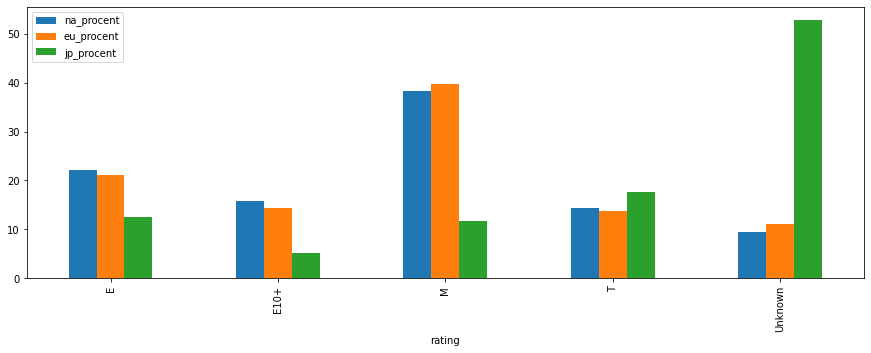

In [53]:
data_rating = data.pivot_table(
    index='rating',
    values=['na_sales','eu_sales','jp_sales']
    , aggfunc='sum'
)

data_rating['na_procent'] = data_rating['na_sales'] / data['na_sales'].sum() * 100
data_rating['eu_procent'] = data_rating['eu_sales'] / data['eu_sales'].sum() * 100
data_rating['jp_procent'] = data_rating['jp_sales'] / data['jp_sales'].sum() * 100

data_rating.plot.bar(y=['na_procent','eu_procent','jp_procent'],figsize=(15,5));

Выставленный рейтинг влияет на продажи в регионах. В регионе EU и NA наблюдается схожая ситуация, игры с рейтингом “М” имеют большой отрыв от игр с другим рейтингом. В JP регионе ситуация другая, лидером продаж являются игры без рейтинга. Возможно, это связано с тем, что ассоциация, которая предоставляет данный рейтинг – американская. 

## Статистический анализ данных

 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
 
 Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Проверим несколько гипотез: 

Первая - средние пользовательские рейтинги платформ Xbox One и PC одинаковые

*H0: Средний пользовательский рейтинг Xbox One равен среднему пользовательскому рейтингу PC*

*H1: Средний пользовательский рейтинг Xbox One не равен среднему пользовательскому рейтингу PC*

In [54]:
sample_xone = data.query('platform == "XOne"')['user_score'].dropna()
sample_pc = data.query('platform == "PC"')['user_score'].dropna()

alpha = .05

results = st.ttest_ind(sample_xone,sample_pc, equal_var = False)
print('P-значение:', results.pvalue)

if results.pvalue > alpha: 
    print('Нет достаточных оснований, чтобы отклонить H0')
else:
    print('Есть достаточные основания, чтобы отклонить Н0, принимаем Н1')

P-значение: 0.6206366351489678
Нет достаточных оснований, чтобы отклонить H0


У нас есть достаточные основания чтобы подтвердить, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые 

Вторая - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

*H0: Средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports*

*H1: Средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports*

In [55]:
sample_action = data.query('genre == "Action"')['user_score'].dropna()
sample_sports = data.query('genre == "Sports"')['user_score'].dropna()

alpha = .05

results = st.ttest_ind(sample_action,sample_sports, equal_var = False)
print('P-значение:', results.pvalue)

if results.pvalue > alpha: 
    print('Нет достаточных оснований, чтобы отклонить H0')
else:
    print('Есть достаточные основания, чтобы отклонить Н0, принимаем Н1')

P-значение: 2.6650913133242695e-19
Есть достаточные основания, чтобы отклонить Н0, принимаем Н1


У нас есть достаточные основания чтобы подтвердить, что средние пользовательские рейтинги жанров Action и Sports отличаются 

Почему гипотезы Н0 и Н1 были сформулированы именно так: Н0 это всегда равенство, в своем исследовании я имею ввиду что среднее для определенной выборке равен среднему для другой выборке. H1 это неравенство, то есть одно среднее не равно другому среднему. Сравнение происходило по независимым выборкам одной генеральной совокупности, поэтому я предпочел для исследования ttest_ind. Ответь точно на вопрос равны ли дисперсии двух выборок не представилось возможным, поэтому в параметрах ttest’а я указал параметр equal_var = False 

## Общий вывод

**В завершении можно сделать вывод о том, что:**

- За актуальный период наиболее прибыльные платформы для игр: PS4, XOne, 3DS, PC, PSV.
- Продажи видеоигр не зависят от отзывов пользователей.
- Жанры с наибольшим стабильным доходом: Shooter, Sports и Platform.
- Пользователи в регионах EU и NA сходи по своим предпочтениям в игровых жанрах и в играх с определенным рейтингом.
- Пользователи в регионе JP отличаются по предпочтениям от пользователей EU и NA в игровых жанрах и в играх с определенным рейтингом.  
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Cредние пользовательские рейтинги жанров Action и Sports отличаются

Исследование проводилось для актуального периода, с 2012 по 2016. Такой период был выбран из-за того, чтобы на полученные выводы не влияли неактуальные данные от устаревших платформ или от жанров, которые со временем утратили свою популярность. Поэтому можно предположить, что полученные выводы в результате исследования будут актуальны и в 2017 году.  

**Рекомендации к закупке на 2017 год:**

Для NA и EU региона стоит обратить внимание на игры: 
- На платформе: PS4, XOne 
- В жанре: Action, Shooter и Sports
- С рейтингом “М”

Для JP региона стоит обратить внимание на игры: 
- На платформе: 3DS, PSV, PS4 
- В жанре: Action, Role-Playing и Misc
- Без рейтига
